# 401 CNN

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* torchvision
* matplotlib

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

#Transformers
from module import *

In [2]:
# Load training data set (small amount to test if it works first)

xtrain = r"data/training_sample_NoSparse.csv.gz"
ytrain = r"data/training_label_NoSparse.csv.gz"
xtest = r"data/testing_sample_NoSparse.csv.gz"
ytest = r"data/testing_label_NoSparse.csv.gz"


In [3]:
#check balance
samplesdf = pd.DataFrame()
for df in  pd.read_csv(ytrain,compression ="gzip",delimiter=',', chunksize = 10000, header=0):
    samplesdf = samplesdf.append(df)
y_train = samplesdf.to_numpy()

num0 = 0
num1 = 0
for x in y_train:
    if x == 0:
        num0 = num0 + 1
    else:
        num1 = num1 + 1
num0,num1 #checking if it is balanced

(15161, 14094)

In [4]:
class Dataset(Dataset):

    def __init__(self,samples,labels,numrows):

        self.data = pd.read_csv(samples,compression ="gzip",delimiter=',', nrows = numrows, header=0)
        self.label = pd.read_csv(labels,compression ="gzip",delimiter=',', nrows = numrows, header=0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        rna = self.data.iloc[idx]
        seplb = self.label.iloc[idx]
        rna = np.array([rna])
        seplb = np.array([seplb])
        rna = rna.astype('double').reshape(-1,3273)
        seplb = seplb.astype('long').reshape(-1)
        sample = {'rna': rna, 'label': seplb}

        return sample

In [5]:
train_dataset = Dataset(samples=xtrain,labels=ytrain,numrows = 29255)
test_dataset = Dataset(samples = xtest,labels = ytest,numrows = 3241)

In [6]:
# Hyper Parameters
EPOCH = 10             # train the training data n times, to save time, we just train 1 epoch
LR = 0.001              # learning rate
batch_size = 32
wd = LR / EPOCH

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (x,1, 8949)
            nn.Conv1d(
                in_channels=1,              # input height
                out_channels=4,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (x,64,8949)
            nn.BatchNorm1d(4),
            nn.ReLU(),                      # activation
        )
        self.conv2 = nn.Sequential(         # input shape (x,64, 8949)
            nn.Conv1d(4,4,3,1,1),            
            nn.ReLU(),  
            nn.Dropout(p=0.1),
            nn.MaxPool1d(kernel_size =2, stride=2,ceil_mode = True),                # output shape (x,64,4478)
        )
        self.conv3 = nn.Sequential(         # input shape (x,64,4478)
            nn.Conv1d(4, 4, 3, 1, 1),     # output shape (x,128,4478)
            nn.ReLU(),                      # activation
            nn.MaxPool1d(kernel_size =2, stride=2,ceil_mode = True),                # output shape (x,128,2238)
        )
        self.out = nn.Linear(3276 , 2)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output  

In [9]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay = wd)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
if torch.cuda.is_available():
    cnn = cnn.cuda()
    loss_func = loss_func.cuda()
cnn = cnn.double()    
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (conv3): Sequential(
    (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (out): Linear(in_features=3276, out_features=2, bias=True)
)


In [10]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

In [11]:
trans = SetTransformer(3273,2,1)
if torch.cuda.is_available():
    trans = trans.cuda()
trans = trans.double()
print(trans)

SetTransformer(
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=3273, out_features=128, bias=True)
        (fc_v): Linear(in_features=3273, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=3273, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): M

In [12]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in train_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1)
            outputs = model(rna)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.reshape(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
           # print(total,correct)

        print('Train Accuracy of the model on the train rna: {} %'.format((correct / total) * 100))
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1)
            outputs = model(rna)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.reshape(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total,correct)

        print('Test Accuracy of the model on the test rna: {} %'.format((correct / total) * 100))



In [20]:
def train(model): 
    total_step = len(train_loader)
    num_epoch = EPOCH
    for epoch in range(num_epoch):
        model.train()
        for i, batch in enumerate(train_loader):
            # Run the forward pass
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            outputs = model(rna)
            labels = labels.long()
            #labels = labels.reshape(-1)
            #print(outputs.shape)
           # print(outputs)
            #print(outputs)
            loss = loss_func(outputs, labels)
            train_losses.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc.append(correct / total)
            if i == 914:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                        .format(epoch + 1, num_epoch , i + 1, total_step, loss.item(),
                                (correct / total) * 100))
        test(model)

In [21]:
train_losses = []
train_acc = []
test_acc = []
train(trans)

Epoch [1/10], Step [915/915], Loss: 0.6917, Accuracy: 57.14%
Train Accuracy of the model on the train rna: 51.84071098957443 %
Test Accuracy of the model on the test rna: 50.601666152422084 %
Epoch [2/10], Step [915/915], Loss: 0.6906, Accuracy: 71.43%
Train Accuracy of the model on the train rna: 51.84071098957443 %
Test Accuracy of the model on the test rna: 50.601666152422084 %
Epoch [3/10], Step [915/915], Loss: 0.6978, Accuracy: 14.29%
Train Accuracy of the model on the train rna: 51.84071098957443 %
Test Accuracy of the model on the test rna: 50.601666152422084 %
Epoch [4/10], Step [915/915], Loss: 0.6928, Accuracy: 57.14%
Train Accuracy of the model on the train rna: 51.84071098957443 %
Test Accuracy of the model on the test rna: 50.601666152422084 %
Epoch [5/10], Step [915/915], Loss: 0.6957, Accuracy: 28.57%
Train Accuracy of the model on the train rna: 51.84071098957443 %
Test Accuracy of the model on the test rna: 50.601666152422084 %
Epoch [6/10], Step [915/915], Loss: 0.69

KeyboardInterrupt: 

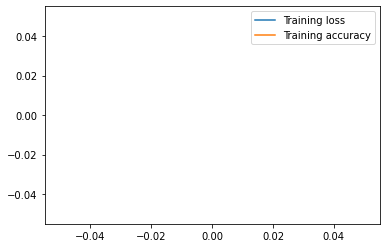

In [15]:
plt.plot(train_losses[200:], label='Training loss')
plt.plot(train_acc[200:], label='Training accuracy')
plt.legend()
plt.show()

No handles with labels found to put in legend.


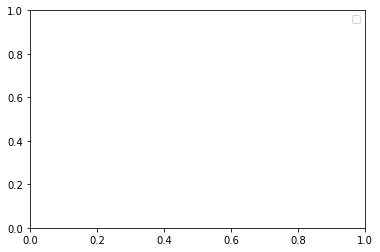

In [16]:

#plt.plot(train_acc[200:], label='Training accuracy')
plt.legend()
plt.show()

In [17]:
# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

NameError: name 'model' is not defined